<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_SE_CPMG_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(SE_CPMG_seq)=
# Spin Echo - CPMG

In [6]:
import numpy as np

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'CPMG'
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50*10e-6
)

Set TE to minTE  0.0051400000000000005
Calculating repetition 13 / 13 - done


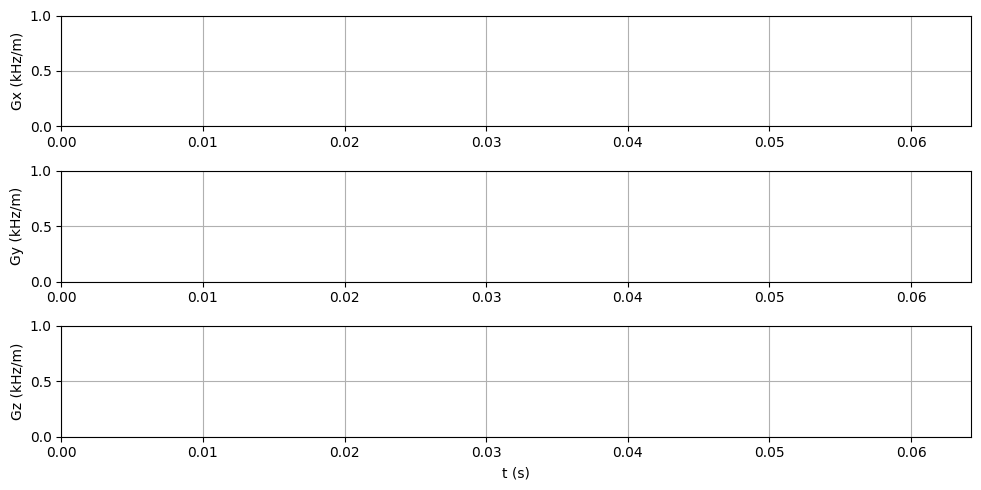

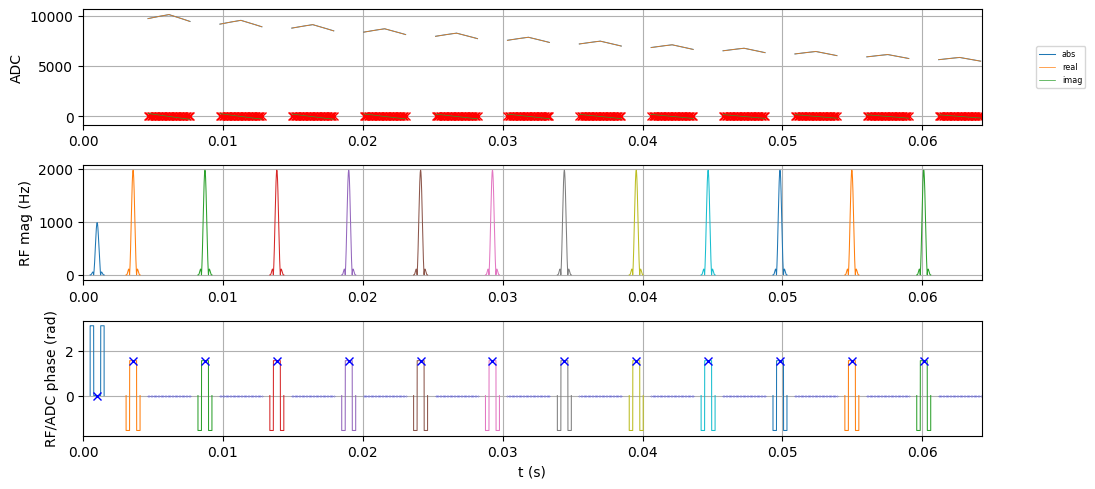

In [8]:
#@title CMPG in a brain phantom - sequence
# %% DEFINE the sequence, FOV and resolution
seq = pp.Sequence(system)
fov = 200e-3
Nread = 31    #@param {type:"slider", min:0, max:512, step:1}
Nphase = 1
slice_thickness = 8e-3  # slice
refocusing_angle=180 #@param {type:"slider", min:0, max:360, step:1}
# Define rf events
ETL=12 #@param {type:"slider", min:1, max:32, step:1}
TE_ms=1 #@param {type:"slider", min:1, max:32, step:1}
TE_ms*=1e-3

rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    delay=0, system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=refocusing_angle * np.pi / 180, duration=1e-3, phase_offset=90 * np.pi / 180,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

sym_rf_block_delay=pp.calc_duration(rf1)-rf1.ringdown_time+rf1.delay

# Define other gradients and ADC events
dwell_time=1e-4
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi / 180, system=system)
minTE = pp.calc_duration(adc)+sym_rf_block_delay
print("Set TE to minTE ",minTE)
TEdelay=(TE_ms-minTE)/2
if TEdelay<0: TEdelay=0

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1,sym_rf_block_delay)
seq.add_block(pp.make_delay(TEdelay+minTE/2 - sym_rf_block_delay))
for i in range(0, ETL):
    seq.add_block(rf2,sym_rf_block_delay)
    seq.add_block(pp.make_delay(TEdelay))
    seq.add_block(adc)
    seq.add_block(pp.make_delay(TEdelay))

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


In [ ]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'CPMG')
seq.write(experiment_id + ".seq")

Timing check passed successfully


'bd38c35b22e47085edfc3b74f3e7395f'